In [1]:
import pickle
X_hr2,y_stress2,y_participant2,X_time2 = pickle.load(open('../data/tabular_data_60_seconds_ppg_rr_dalia_normalized.p','rb'))

X_hr2 = X_hr2.reshape(-1,30,1)

In [2]:
import pickle
X_hr1,y_stress1,y_participant1,X_time1 = pickle.load(open('../data/tabular_data_60_seconds_ppg_rr_normalized.p','rb'))

X_hr1 = X_hr1.reshape(-1,30,1)

In [3]:
import numpy as np
X_hr = np.concatenate([X_hr2,X_hr1])

In [4]:
y_participant = np.array(list(y_participant2)+list(y_participant1+np.max(y_participant1)+1))

In [5]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[3], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,LeaveOneGroupOut,LeavePGroupsOut
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import backend as K 
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib notebook
from keras.layers import Conv1D,Reshape,BatchNormalization,TimeDistributed, \
Dropout,Input,MaxPooling1D,Flatten,Dense,Input, GaussianNoise,LSTM, Bidirectional, Input
from keras.models import Model, Sequential
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer,LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats.mstats import winsorize


class Scrambler:
    def __init__(self, region_length=1,n_timesteps=30):
        self.n_timesteps = n_timesteps
        self.splits = n_timesteps//region_length
    def __call__(self, x):
        x = tf.reshape(x,(-1,self.n_timesteps))
        x = tf.transpose(x)
        xs = tf.split(x,self.splits)
        x = tf.transpose(tf.reshape(tf.concat(tf.gather(xs,tf.random.shuffle(tf.range(self.splits))),axis=0),(self.n_timesteps,-1)))
        x = tf.reshape(x,(-1,self.n_timesteps,1))
        return x

def get_model(input_shape=(30,1),act='relu',loss="categorical_crossentropy",opt='adam',
              n_classes=350,n_region=1):
    
    model =  Sequential()
    model.add(Input(shape=input_shape))
    model.add(Reshape(input_shape))
    model.add(tf.keras.layers.Lambda(Scrambler(n_region),name='shuffling'))
    model.add(Conv1D(100,10,input_shape=input_shape,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(Conv1D(100,10,input_shape=input_shape,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(200,10,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(300,10,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Conv1D(50,2,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Flatten())
    model.add(Dense(n_classes,activation='relu'))
    model.add(Dense(n_classes,activation='sigmoid'))
    model.add(Dense(n_classes,activation='softmax'))
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer=opt)
    return model

result = []
for k in [30,15,10,6,5,3,2,1]:
    train_participant = y_participant.copy()

    train_x = winsorize(X_hr.reshape(-1,30),limits=[0,0],axis=1).reshape(-1,30,1)
    train_y = y_participant.copy()

    train_x, test_x, train_y, test_y,participant_ids_train, participant_ids_test = train_test_split(train_x,
                                                                train_participant,
                                                                y_participant,
                                                                test_size = 0.3,
                                                                random_state=41,
                                                                stratify=y_participant)
    train_x, val_x, train_y, val_y, participant_ids_train, participant_ids_val  = train_test_split(train_x,
                                                                train_y,
                                                                participant_ids_train,
                                                                test_size = 0.1,
                                                                random_state=41,
                                                                stratify=participant_ids_train)

    n_classes = 200
    n_output = len(np.unique(y_participant))
    model = get_model(input_shape=(30,1),n_classes=n_output,n_region=k) 
    #     model.summary()

    # model.layers[0]

    from keras.models import load_model
    filepath = '../model_files/base_cnn_60_seconds_ppg_hr_wesad_dalia_combined_only_classification.hdf5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min',save_weights_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0,patience=40)
    callbacks_list = [es,checkpoint]

    history = model.fit(train_x,train_y,validation_data=(val_x,val_y), epochs=1000, 
                        batch_size=500,callbacks=callbacks_list,shuffle=True,verbose=0)

    model = get_model(input_shape=(30,1),n_classes=n_output,n_region=k) 
    model.summary()
    model.load_weights(filepath)
    test_y_pred = model.predict(test_x).argmax(axis=1)

    from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
    result.append(np.array([k,accuracy_score(test_y,test_y_pred)]))
    print(accuracy_score(test_y,test_y_pred))
    print(classification_report(test_y,test_y_pred))
    # # # model = load_model(filepath)

4 Physical GPUs, 1 Logical GPU
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 30, 1)             0         
_________________________________________________________________
shuffling (Lambda)           (None, 30, 1)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 30, 100)           1100      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 30, 100)           100100    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 15, 100)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 100)           400       
_________________________________________________________________
dropout_3 (Dropout)    

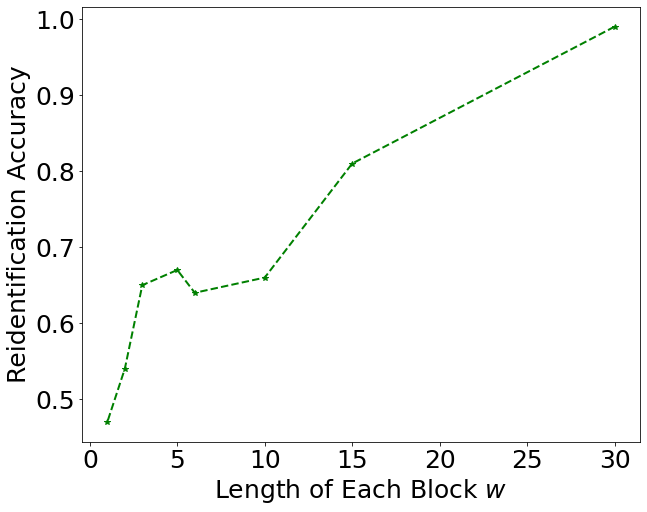

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

x = [30,15,10,6,5,3,2,1]
y = [.99,.81,.66,.64,.67,.65,.54,.47]
plt.rcParams.update({'font.size':25})
plt.figure(figsize=(10,8))
plt.plot(x,y,'*--g',linewidth=2)
plt.xlabel('Length of Each Block '+r'$w$')
plt.ylabel('Reidentification Accuracy')
plt.show()

In [ ]:
# test_embeddings = model.predict(test_x)
test_y_pred = model.predict(test_x).argmax(axis=1)

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
result.append(np.array([k,accuracy_score(test_y,test_y_pred)]))
print(accuracy_score(test_y,test_y_pred))
print(classification_report(test_y,test_y_pred))

In [ ]:
test_y_pred = model.predict(test_x).argmax(axis=1)

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
# result.append(np.array([k,accuracy_score(test_y,test_y_pred)]))
print(accuracy_score(test_y,test_y_pred))
print(classification_report(test_y,test_y_pred))

In [ ]:
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
train_embeddings_pca = TSNE(n_components=2).fit_transform(test_embeddings)
plt.figure()
plt.scatter(train_embeddings_pca[:,0],train_embeddings_pca[:,1],c=test_y)
plt.colorbar()
plt.show()

In [ ]:
import tensorflow as tf

In [ ]:
tf.random.shuffle(tf.convert_to_tensor(np.arange(10).reshape(10,1),dtype=tf.float32))

In [ ]:
import pickle
test_dalia_x,test_dalia_y_stress,test_dalia_y,test_dalia_time = pickle.load(open('../data/tabular_data_60_seconds_ppg_rr_dalia_normalized.p',
                                                                                 'rb'))

In [ ]:
test_dalia_x = test_dalia_x.reshape(-1,30,1)

In [ ]:
test_dalia_embeddings = model.predict(test_dalia_x)

In [ ]:
train_embeddings_pca = TSNE(n_components=2).fit_transform(test_dalia_embeddings)
plt.figure()
plt.scatter(train_embeddings_pca[:,0],train_embeddings_pca[:,1],c=test_dalia_y)
plt.colorbar()
plt.show()

In [ ]:
model = get_model(input_shape=(30,1),n_classes=n_classes,n_output=n_output,loss=custom_loss) 
model.summary()
model.load_weights(filepath)

In [ ]:
y_pred = model.predict(test_x).argmax(axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
print(confusion_matrix(test_y,y_pred))

In [ ]:
%matplotlib inline
def get_clusters(model,train_x,train_y):
    train_embeddings = model.predict(train_x)

    from sklearn.decomposition import PCA

    train_embeddings_pca = PCA(n_components=20).fit_transform(train_embeddings)

    plt.figure()
    plt.scatter(train_embeddings_pca[:,0],train_embeddings_pca[:,1],c=train_y)
    plt.show()
get_clusters(model,test_x,test_y)

In [ ]:
import pickle
test_dalia_x,test_dalia_y_stress,test_dalia_y,test_dalia_time = pickle.load(open('../data/tabular_data_60_seconds_ppg_rr_dalia.p',
                                                                                 'rb'))
test_dalia_x = test_dalia_x.reshape(-1,30,1)
get_clusters(model,test_dalia_x,test_dalia_y)

In [ ]:
def give_rank_accuracy(train_embeddings,train_y,rank = 10):
    distance_matrix = euclidean_distances(train_embeddings)
    distance_matrix_2d = np.zeros((distance_matrix.shape[0],
                               distance_matrix.shape[0],
                               2))
    distance_matrix_2d[:,:,0] = distance_matrix
    train_y_matrix = np.concatenate([train_y.reshape(1,-1)]*distance_matrix.shape[0])
    distance_matrix_2d[:,:,1] = train_y_matrix
    match = 0
    for i in range(distance_matrix.shape[0]):
        row = distance_matrix_2d[i]
        row = row[row[:,0].argsort(),:]
        if rank==1:
            if train_y[i]==row[1,1]:
                match+=1
        else:
            row = set(row[1:(rank+1)][:,1])
            if train_y[i] in row:
                match+=1
    return match/distance_matrix.shape[0]

In [ ]:
rank_1 = give_rank_accuracy(train_embeddings,train_y,rank = 1)
rank_5 = give_rank_accuracy(train_embeddings,train_y,rank = 5)
rank_10 = give_rank_accuracy(train_embeddings,train_y,rank = 10)
print(rank_1,rank_5,rank_10)

In [ ]:
test_embeddings = model.predict(test_x)

In [ ]:
rank_1 = give_rank_accuracy(test_embeddings,test_y,rank = 1)
rank_5 = give_rank_accuracy(test_embeddings,test_y,rank = 5)
rank_10 = give_rank_accuracy(test_embeddings,test_y,rank = 10)
print(rank_1,rank_5,rank_10)

In [ ]:
test_x,y_stress,test_y,X_time = pickle.load(open('../data/tabular_data_60_seconds_ppg_rr_dalia.p','rb'))

In [ ]:
test_x = test_x.reshape(-1,30,1)

In [ ]:
test_embeddings = model.predict(test_x)
rank_1 = give_rank_accuracy(test_embeddings,test_y,rank = 1)
rank_5 = give_rank_accuracy(test_embeddings,test_y,rank = 5)
rank_10 = give_rank_accuracy(test_embeddings,test_y,rank = 10)
print(rank_1,rank_5,rank_10)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(train_y,train_y_pred))
print(confusion_matrix(train_y,train_y_pred))

In [ ]:
tf.keras.layers.GaussianNoise(tf.random.uniform((30,1),minval=10,maxval=11))(test_x[0]),test_x[0]

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Lambda(lambda x:tf.random.shuffle(x)))

In [ ]:
tf.reshape(model(tf.convert_to_tensor(np.arange(10*30).reshape(5,2,1),dtype=tf.float32)),(2,5,1))

In [ ]:
x = tf.convert_to_tensor(np.arange(10*30).reshape(-1,30))
x = tf.reshape(x,(10,30))
# x = tf.random.shuffle(x)
# x = tf.reshape(x,(-1,30))
x

In [ ]:
x

In [ ]:
def custom_layer(x):
    x = tf.reshape(x,(-1,30))
    x = tf.transpose(tf.random.shuffle(tf.transpose(x)))
    x = tf.reshape(x,(-1,15,2))
    return x

In [ ]:
class Scrambler:
    def __init__(self, region_length=1,n_timesteps=30):
        self.n_timesteps = n_timesteps
        self.splits = n_timesteps//region_length
    def __call__(self, x):
        x = tf.reshape(x,(-1,self.n_timesteps))
        x = tf.transpose(x)
        xs = tf.split(x,self.splits)
        x = tf.transpose(tf.reshape(tf.concat(tf.gather(xs,tf.random.shuffle(tf.range(self.splits))),axis=0),(self.n_timesteps,-1)))
        x = tf.reshape(x,(-1,self.n_timesteps,1))
        return x

model = Sequential()
model.add(tf.keras.layers.Lambda(Scrambler(3)))

In [ ]:
test_x[:1]

In [ ]:
model(test_x)[:1]

In [ ]:
tf.concat(tf.gather(xs,tf.random.shuffle(tf.range(5))),axis=0)

In [ ]:
tf.